<a href="https://colab.research.google.com/github/deepaksirohiwal/Deep_Learning_with_PyTorch/blob/main/DeepLearning_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Loading dataset
Loading the Fashion-MNIST dataset from TorchVision. Fashion-MNIST is a dataset of Zalando’s article images consisting of 60,000 training examples and 10,000 test examples. Each example comprises a 28×28 grayscale image and an associated label from one of 10 classes.


---

* root: Path where the train/test data is store
* train: Specifies training or test data
* download=True: download the data from the internet if not available at the root
* transform and target_transform : specify the feature and label transformation

In [3]:
training_data= datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data= datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 17779225.45it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 297739.16it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5489192.20it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19611514.07it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

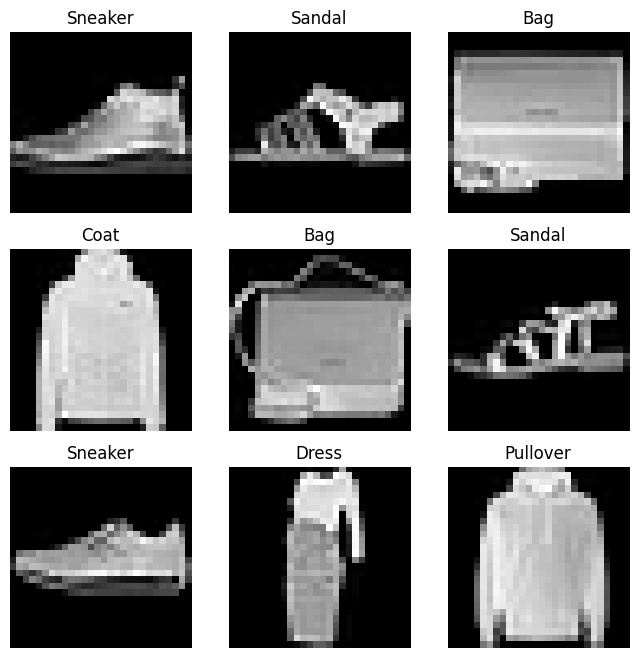

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [6]:
train_dataloader= DataLoader(training_data, batch_size=64,shuffle=True)
test_dataloader= DataLoader(test_data,batch_size=64, shuffle=True)

In [7]:
next(iter(train_dataloader))[0].size()

torch.Size([64, 1, 28, 28])

Feature batch shape: torch.Size([64, 1, 28, 28])
Lables batch shape: torch.Size([64])


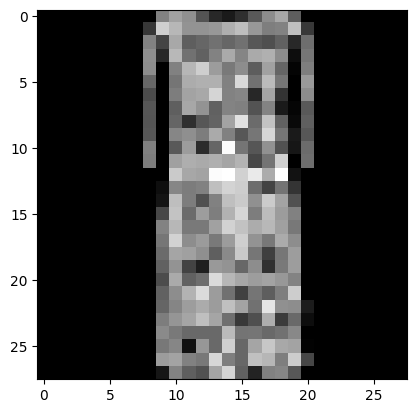

Label: 3


In [8]:
train_features, train_labels= next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Lables batch shape: {train_labels.size()}")
img= train_features[0].squeeze()
label=train_labels[0]
plt.imshow(img,cmap='gray')
plt.show()
print(f"Label: {label}")

## Transform

Data often arrives in forms that might not be immediately suitable for training machine learning algorithms. To prepare such data, we employ transformations that modify it into the required format. For this purpose, TorchVision datasets include two parameters: `transform` and `target_transform`. These parameters accept callable functions that encapsulate the transformation process. The torchvision.transforms module conveniently provides a range of standard transformations.

For instance, in the case of FashionMNIST, the data's features are typically presented as PIL Images, while the labels are represented as integers. However, for effective training, the features need to be normalized tensors, and the labels require one-hot encoding. To perform these essential transformations, we leverage two specific transformations: ToTensor and Lambda.

- **ToTensor**: This transformation converts PIL Images or similar data formats into tensors. It also scales the pixel values to a range between 0 and 1, making the data suitable for neural networks.

- **Lambda**: The Lambda transformation is used to apply custom functions to the data. In this context, it facilitates the conversion of integer labels to one-hot encoded tensors, a necessary step for various classification tasks.

In [9]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

**ToTensor** converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

**Lambda Transforms**

1. **Lambda Transformation**: The `Lambda` transformation is a flexible way to apply custom transformations to the target data. It accepts a callable function and applies it to each target label.

2. **lambda Function**: Inside the `Lambda` transformation, there's a lambda function that takes a label `y` as input.

3. **torch.zeros()**: This creates a tensor of zeros. In this case, it creates a tensor of shape `(10,)` with all values initialized to 0. This tensor will eventually represent the one-hot encoded label.

4. **scatter_()**: The `scatter_` method is a powerful PyTorch function used for in-place modification of the tensor. It allows you to scatter (set) values at specified indices along a given dimension.

5. **dim**: The `dim` parameter specifies the dimension along which the scattering operation is performed. In this case, it's the first dimension (index 0).

6. **index**: The `index` parameter specifies the indices where the value 1 should be placed. The `torch.tensor(y)` is a tensor that holds the original label `y`.

7. **value**: The `value` parameter specifies the value to scatter. In this case, it's 1.

In summary, the code creates a `target_transform` that, when applied to a label `y`, returns a one-hot encoded tensor where the element corresponding to the original label `y` is set to 1, and all other elements are set to 0. The `scatter_` method efficiently achieves this by modifying the existing zero tensor using the index provided by the original label `y`.

For example, if `y` is 3, the corresponding one-hot encoded tensor will be `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`, where the fourth element (index 3) is set to 1, representing the class label 3.

# Building Neural Network


Neural networks are constructed using building blocks known as layers or modules. These modules perform various operations on data. In PyTorch, the `torch.nn` namespace offers a comprehensive set of tools for creating neural networks. Each building block in PyTorch inherits from `nn.Module`, forming a structured foundation for constructing customized neural networks.

In PyTorch, a neural network is essentially a module that encompasses multiple other modules or layers. This hierarchical arrangement simplifies the design and administration of intricate network architectures. Through this nested structure, the process of constructing and controlling complex models becomes more intuitive and manageable.

In [9]:
# class NeuralNetwork(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.flatten=nn.Flatten()